# Projeto IA – Previsão do vencedor do Mundial 2026

**Unidade Curricular:** Inteligência Artificial  
**Tema:** Análise de dados das World Cups e rankings FIFA para previsão do Mundial 2026  

**Autores:** \<António Ferreira, Mafalda Barão, Gonsalo Gomes, Rúben Dias, João Morais>  
**Docente:** \<Rui Fernandes>  
**Data:** \<11/2025>

---

## Objetivo do notebook

Neste notebook vamos:

1. Carregar e explorar 3 datasets:
   - `WorldCups.csv` – informação agregada por edição do Mundial.
   - `WorldCupMatches.csv` – informação ao nível de cada jogo.
   - `fifa_ranking-2024-06-20.csv` – histórico de rankings FIFA das seleções.
2. Fazer análise exploratória (EDA) dos dados.
3. Integrar informação dos rankings FIFA com as edições do Mundial.
4. Construir um primeiro modelo simples para prever o vencedor de uma edição do Mundial.
5. Discutir como isto pode ser usado (mais tarde) para estimar o vencedor do Mundial 2026.


# Imports principais

In [2]:
# Bibliotecas principais
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Descrição dos datasets

## 1. Descrição dos datasets

- **WorldCups.csv**
  - Uma linha por edição da World Cup.
  - Colunas principais: `Year`, `Country` (país anfitrião), `Winner`, `Runners-Up`,
    `GoalsScored`, `QualifiedTeams`, `MatchesPlayed`, `Attendance`, etc.

- **WorldCupMatches.csv**
  - Uma linha por jogo.
  - Colunas principais: `Year`, `Stage`, `Home Team Name`, `Home Team Goals`,
    `Away Team Name`, `Away Team Goals`, `Attendance`, etc.

- **fifa_ranking-2024-06-20.csv**
  - Várias linhas por seleção ao longo do tempo.
  - Colunas principais: `country_full`, `rank`, `total_points`, `confederation`,
    `rank_date`, etc.



# Carregar datasets

In [5]:
# Carregar os datasets (ajusta o caminho se necessário)
wc = pd.read_csv("data\WorldCups.csv")
matches = pd.read_csv("data\WorldCupMatches.csv")
ranking = pd.read_csv("data\\fifa_ranking-2024-06-20.csv")

print("WorldCups:")
display(wc.head())

print("\nWorldCupMatches:")
display(matches.head())

print("\nFIFA Ranking:")
display(ranking.head())

WorldCups:


<>:2: SyntaxWarning: "\W" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\W"? A raw string is also an option.
<>:3: SyntaxWarning: "\W" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\W"? A raw string is also an option.
<>:2: SyntaxWarning: "\W" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\W"? A raw string is also an option.
<>:3: SyntaxWarning: "\W" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\W"? A raw string is also an option.
C:\Users\Mafalda\AppData\Local\Temp\ipykernel_15972\1624545913.py:2: SyntaxWarning: "\W" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\W"? A raw string is also an option.
  wc = pd.read_csv("data\WorldCups.csv")
C:\Users\Mafalda\AppData\Local\Temp\ipykernel_15972\1624545913.py:3: SyntaxWarning: "\W" is an invalid escape sequence. Such sequen

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363.000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607



WorldCupMatches:


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA



FIFA Ranking:


,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,140.0,Brunei Darussalam,BRU,2.0,0.0,140,AFC,1992-12-31
1,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
2,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
3,31.0,Greece,GRE,38.0,0.0,31,UEFA,1992-12-31
4,30.0,Algeria,ALG,39.0,0.0,30,CAF,1992-12-31


# Limpeza básica e tipos

In [ ]:
# Ver informação geral
print("WorldCups info:")
wc.info()
print("\nWorldCupMatches info:")
matches.info()
print("\nRanking info:")
ranking.info()

# --- Limpeza WorldCups ---

# Tirar espaços dos nomes das colunas e substituir espaços por underscore
wc.columns = [c.strip().replace(" ", "_") for c in wc.columns]

# Converter Year para inteiro (garantia)
wc["Year"] = wc["Year"].astype(int)

# Attendance vem como string com pontos como separador de milhares (ex: "3.587.538")
if "Attendance" in wc.columns:
    wc["Attendance"] = wc["Attendance"].astype(str).str.replace(".", "", regex=False)
    wc["Attendance"] = pd.to_numeric(wc["Attendance"], errors="coerce")

display(wc.head())

# --- Limpeza WorldCupMatches ---

# limpar nomes das colunas
matches.columns = [c.strip().replace(" ", "_") for c in matches.columns]

# Corrigir Year para numérico
matches["Year"] = pd.to_numeric(matches["Year"], errors="coerce")

# OPCIONAL: ver quantos anos ficaram como NaN
print("Linhas sem Year:", matches["Year"].isna().sum())

# remover linhas sem Year
matches = matches.dropna(subset=["Year"])

matches["Year"] = matches["Year"].astype(int)

# Goals e Attendance para numérico
for col in ["Home_Team_Goals", "Away_Team_Goals",
            "Half-time_Home_Goals", "Half-time_Away_Goals"]:
    if col in matches.columns:
        matches[col] = pd.to_numeric(matches[col], errors="coerce")

if "Attendance" in matches.columns:
    matches["Attendance"] = matches["Attendance"].astype(str).str.replace(".", "", regex=False)
    matches["Attendance"] = pd.to_numeric(matches["Attendance"], errors="coerce")

display(matches.head())


# Goals e Attendance para numérico
for col in ["Home_Team_Goals", "Away_Team_Goals", "Half-time_Home_Goals", "Half-time_Away_Goals"]:
    if col in matches.columns:
        matches[col] = pd.to_numeric(matches[col], errors="coerce")

if "Attendance" in matches.columns:
    matches["Attendance"] = matches["Attendance"].astype(str).str.replace(".", "", regex=False)
    matches["Attendance"] = pd.to_numeric(matches["Attendance"], errors="coerce")

display(matches.head())

# --- Limpeza Ranking FIFA ---

ranking["rank_date"] = pd.to_datetime(ranking["rank_date"])
ranking["year"] = ranking["rank_date"].dt.year

display(ranking.head())


WorldCups info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Year            20 non-null     int64 
 1   Country         20 non-null     object
 2   Winner          20 non-null     object
 3   Runners-Up      20 non-null     object
 4   Third           20 non-null     object
 5   Fourth          20 non-null     object
 6   GoalsScored     20 non-null     int64 
 7   QualifiedTeams  20 non-null     int64 
 8   MatchesPlayed   20 non-null     int64 
 9   Attendance      20 non-null     int64 
dtypes: int64(5), object(5)
memory usage: 1.7+ KB

WorldCupMatches info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  852 non-null    Int64  
 1   Datetime       

,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1045246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768607


Linhas sem Year: 3720


,Year,Datetime,Stage,Stadium,City,Home_Team_Name,Home_Team_Goals,Away_Team_Goals,Away_Team_Name,Win_conditions,Attendance,Half-time_Home_Goals,Half-time_Away_Goals,Referee,Assistant_1,Assistant_2,RoundID,MatchID,Home_Team_Initials,Away_Team_Initials
0,1930,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,44440.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,183460.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,240590.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,25490.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,234090.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


,Year,Datetime,Stage,Stadium,City,Home_Team_Name,Home_Team_Goals,Away_Team_Goals,Away_Team_Name,Win_conditions,Attendance,Half-time_Home_Goals,Half-time_Away_Goals,Referee,Assistant_1,Assistant_2,RoundID,MatchID,Home_Team_Initials,Away_Team_Initials
0,1930,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,444400.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,1834600.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,2405900.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,254900.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,2340900.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,year
0,140.0,Brunei Darussalam,BRU,2.0,0.0,140,AFC,1992-12-31,1992
1,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31,1992
2,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31,1992
3,31.0,Greece,GRE,38.0,0.0,31,UEFA,1992-12-31,1992
4,30.0,Algeria,ALG,39.0,0.0,30,CAF,1992-12-31,1992


# EDA: WorldCups

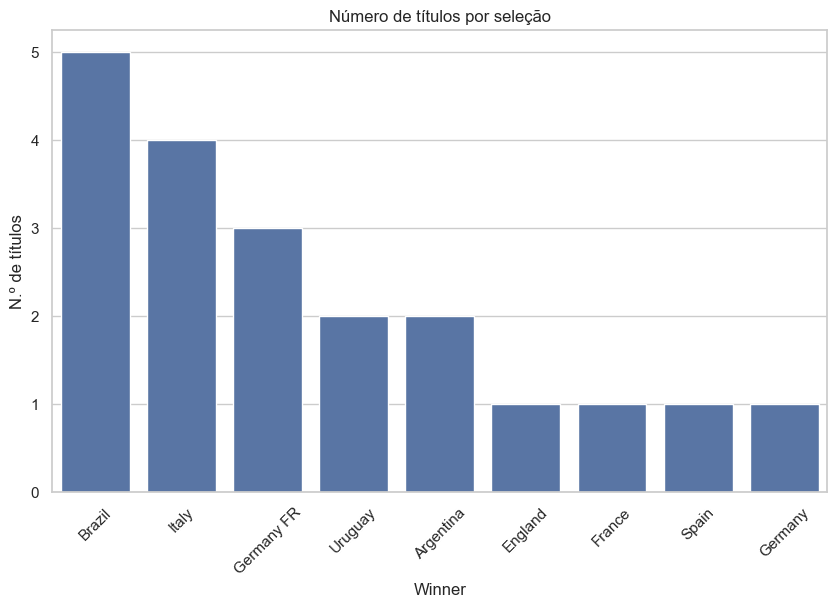

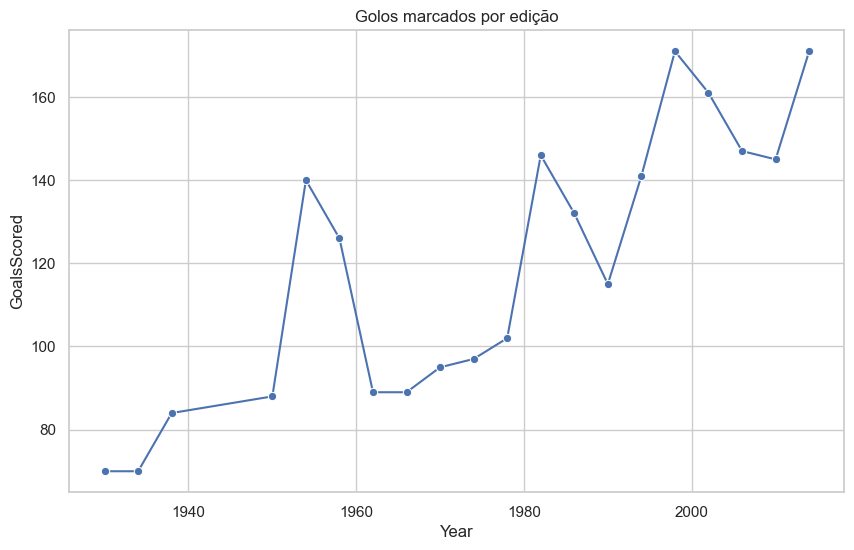

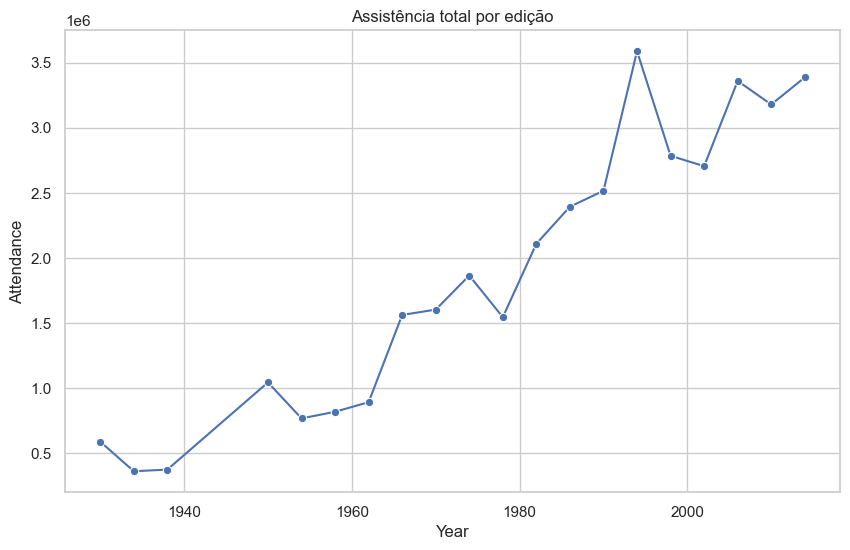

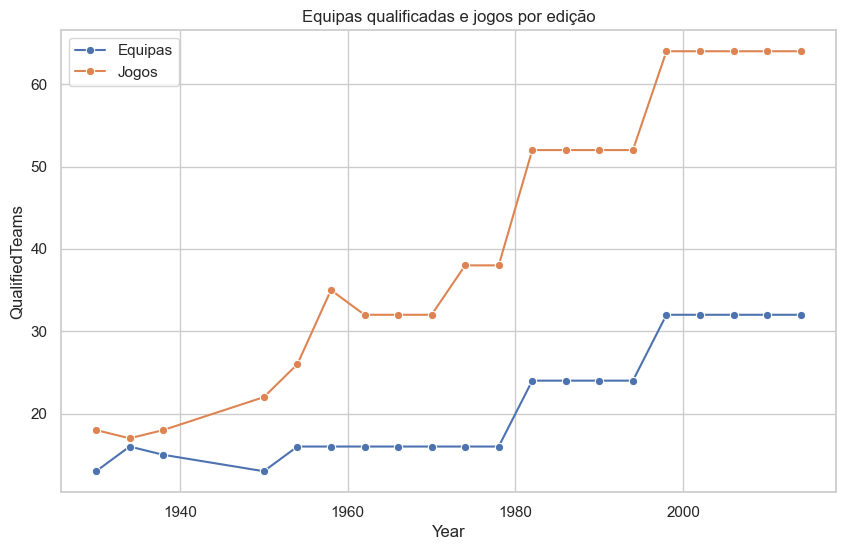

In [10]:
# Distribuição de títulos por seleção
if "Winner" in wc.columns:
    winners_counts = wc["Winner"].value_counts()
    sns.barplot(x=winners_counts.index, y=winners_counts.values)
    plt.title("Número de títulos por seleção")
    plt.xticks(rotation=45)
    plt.ylabel("N.º de títulos")
    plt.show()

# Golos por edição
if "GoalsScored" in wc.columns:
    sns.lineplot(data=wc, x="Year", y="GoalsScored", marker="o")
    plt.title("Golos marcados por edição")
    plt.show()

# Evolução da assistência total
if "Attendance" in wc.columns:
    sns.lineplot(data=wc, x="Year", y="Attendance", marker="o")
    plt.title("Assistência total por edição")
    plt.show()

# Número de equipas e jogos
if {"QualifiedTeams", "MatchesPlayed"}.issubset(wc.columns):
    fig, ax = plt.subplots()
    sns.lineplot(data=wc, x="Year", y="QualifiedTeams", marker="o", ax=ax, label="Equipas")
    sns.lineplot(data=wc, x="Year", y="MatchesPlayed", marker="o", ax=ax, label="Jogos")
    plt.title("Equipas qualificadas e jogos por edição")
    plt.legend()
    plt.show()


# EDA: WorldCupMatches

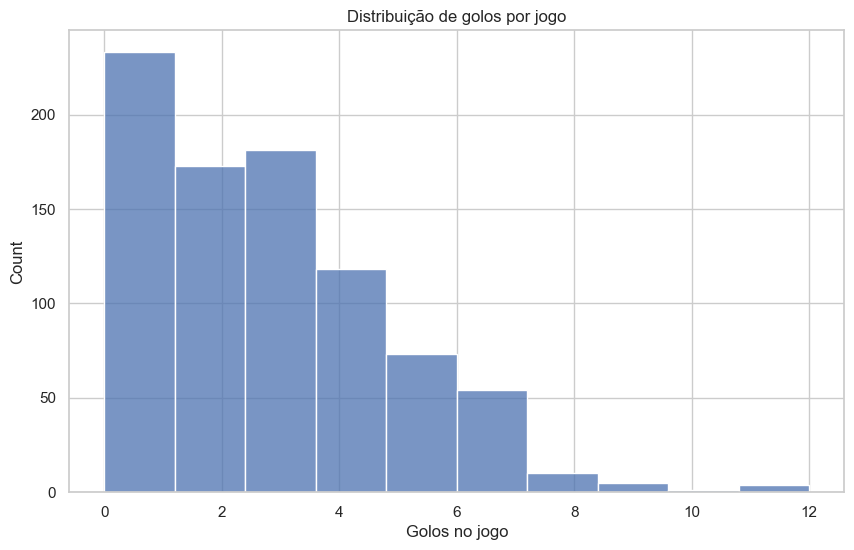

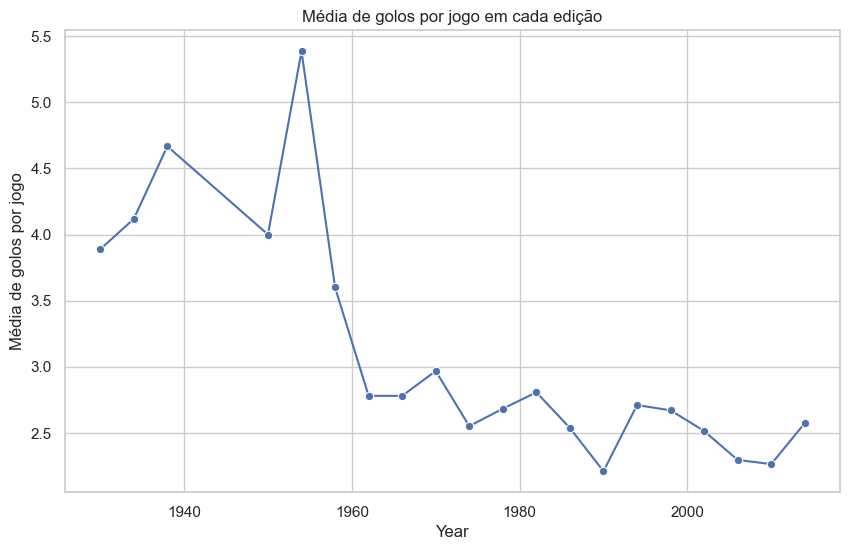

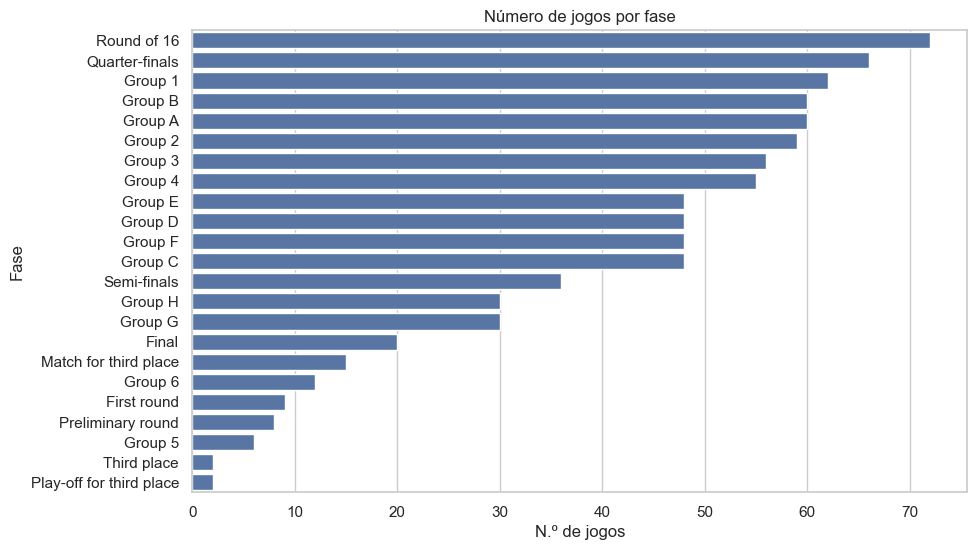

In [11]:
# Total de golos por jogo
matches["Total_Goals"] = matches["Home_Team_Goals"] + matches["Away_Team_Goals"]

sns.histplot(matches["Total_Goals"].dropna(), bins=10)
plt.title("Distribuição de golos por jogo")
plt.xlabel("Golos no jogo")
plt.show()

# Média de golos por edição
avg_goals_year = matches.groupby("Year")["Total_Goals"].mean().reset_index()
sns.lineplot(data=avg_goals_year, x="Year", y="Total_Goals", marker="o")
plt.title("Média de golos por jogo em cada edição")
plt.ylabel("Média de golos por jogo")
plt.show()

# Distribuição dos jogos por fase (Stage)
if "Stage" in matches.columns:
    stage_counts = matches["Stage"].value_counts()
    sns.barplot(y=stage_counts.index, x=stage_counts.values)
    plt.title("Número de jogos por fase")
    plt.xlabel("N.º de jogos")
    plt.ylabel("Fase")
    plt.show()


# EDA: Ranking FIFA + exemplo com Portugal

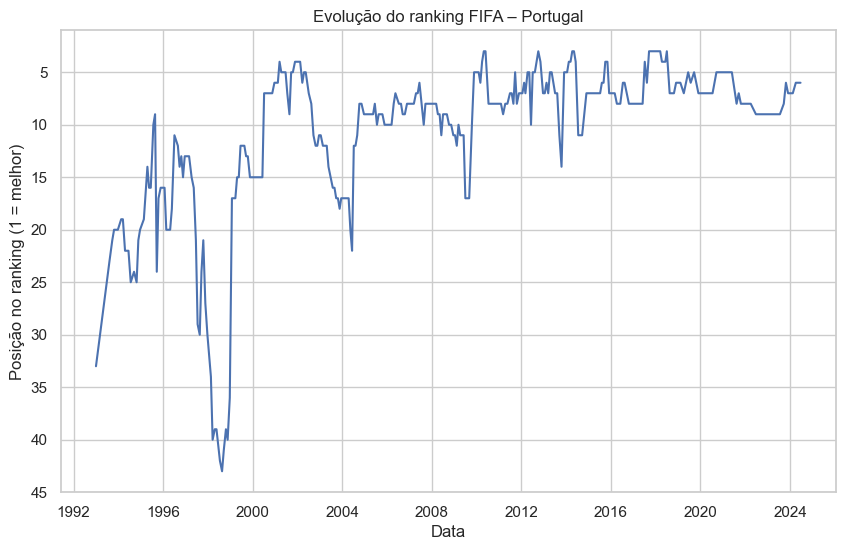

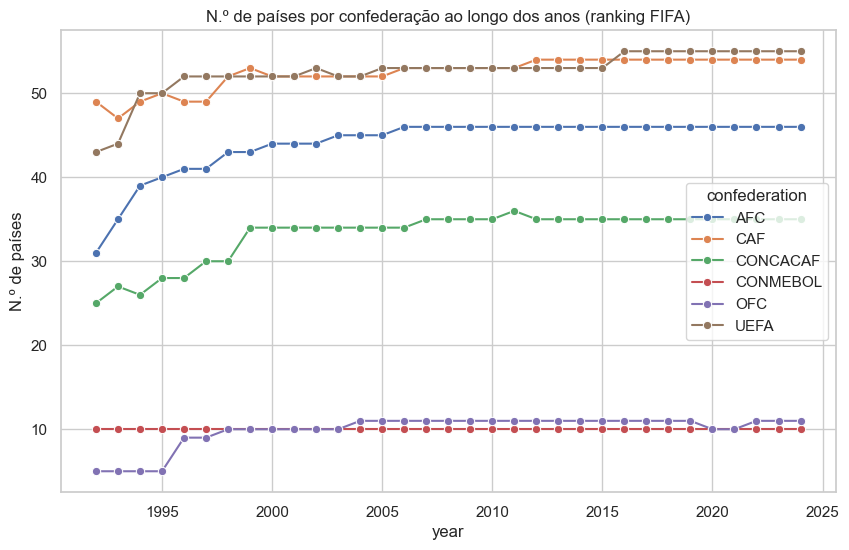

In [12]:
# Exemplo: evolução do ranking de Portugal ao longo do tempo
portugal_rank = ranking[ranking["country_full"] == "Portugal"].sort_values("rank_date")

plt.plot(portugal_rank["rank_date"], portugal_rank["rank"])
plt.gca().invert_yaxis()  # rank 1 é melhor => fica em cima
plt.title("Evolução do ranking FIFA – Portugal")
plt.xlabel("Data")
plt.ylabel("Posição no ranking (1 = melhor)")
plt.show()

# Número de países por confederação ao longo do tempo (última data de cada ano)
last_rank_per_year = ranking.sort_values("rank_date").drop_duplicates(
    subset=["year", "country_full"], keep="last"
)

conf_counts = last_rank_per_year.groupby(["year", "confederation"])["country_full"].nunique().reset_index()
sns.lineplot(data=conf_counts, x="year", y="country_full", hue="confederation", marker="o")
plt.title("N.º de países por confederação ao longo dos anos (ranking FIFA)")
plt.ylabel("N.º de países")
plt.show()
